In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr
from sedona.register import SedonaRegistrator  
from sedona.utils import SedonaKryoRegistrator, KryoSerializer

### Sedona
#### Prepare sedona-spark-shaded jar
https://sedona.apache.org/latest-snapshot/setup/install-python/
For Spark 3.4+ and Scala 2.12, it is called sedona-spark-shaded-3.4_2.12-1.4.1.jar. If you are using Spark versions higher than 3.4, please replace the 3.4 in artifact names with the corresponding major.minor version numbers.

In [21]:
# import sedona
from sedona.spark import *

# set up a configurtation for 
config = SedonaContext.builder(). \
    config('spark.jars.packages',
           'org.apache.sedona:sedona-spark-shaded-3.0_2.12:1.4.1,'
           'org.datasyslab:geotools-wrapper:1.4.0-28.2'). \
    getOrCreate()

# Initialize a Sedona PySpark session with the specific configuration
sedona = SedonaContext.create(config)

In [4]:
sedona

In [24]:
# Define the list of shapefile paths
shapefile_paths = [
    'testdaten_alkis_shape_25832/ALKIS-Vereinfacht/Flurstueck.shp',
    'testdaten_alkis_shape_25832/ALKIS-Vereinfacht/GebaeudeBauwerk.shp',
    'testdaten_alkis_shape_25832/ALKIS-Vereinfacht/KatasterBezirk.shp',
    'testdaten_alkis_shape_25832/ALKIS-Vereinfacht/Nutzung.shp',
    'testdaten_alkis_shape_25832/ALKIS-Vereinfacht/VerwaltungsEinheit.shp'
]

# Create Sedona DataFrames for each shapefile
sedona_dataframes = {}
for path in shapefile_paths:
    gdf = gpd.read_file(path)
    sedona_dataframes[path] = sedona.createDataFrame(gdf)

In [26]:
sedona_dataframes['testdaten_alkis_shape_25832/ALKIS-Vereinfacht/Flurstueck.shp']

DataFrame[gml_id: string, oid: string, aktualit: string, idflurst: string, flaeche: double, flstkennz: string, flstnrzae: string, flstnrnen: string, gemarkung: string, gemaschl: string, land: string, landschl: string, regbezirk: string, regbezschl: string, kreis: string, kreisschl: string, gemeinde: string, gmdschl: string, abwrecht: string, lagebeztxt: string, tntxt: string, geometry: udt]

### Simple SQL on the data

In [39]:
# temporary view from the flurestuecke DataFrame
sedona_dataframes['C:/alkis_shape_utm32/Flurstueck.shp'].createOrReplaceTempView("flurstueck")

# temporary view from the flurestuecke DataFrame
sedona_dataframes['C:/alkis_shape_utm32/Nutzung.shp'].createOrReplaceTempView("nutzung")

In [40]:
counties_geom = sedona.sql(
      "SELECT land, geometry as geometry from Flurstueck"
)

## Flurstück with Nutzung = "Landwirtschaft" and Flaeche > 1000
### Sedona Spark Spatial Join 
Flächen mit einer einheitlichen Nutzklasse Landwirtschaft und mit mehr als 1000qm

In [42]:
# Perform the SQL join and selection
result = sedona.sql("""
    SELECT 
    flurstueck.geometry AS flurstueck_geometry, 
    nutzung.geometry AS nutzung_geometry
    FROM 
        flurstueck
        JOIN nutzung ON ST_Within(nutzung.geometry, flurstueck.geometry)
    WHERE flurstueck.flaeche > 1000 AND nutzung.nutzart = "Landwirtschaft"
""")


### GeoPandas Spatial join
In a spatial join, two geometry objects are merged based on their spatial relationship to one another.

In [2]:
import folium
import geopandas as gpd
import matplotlib.pyplot as plt


In [99]:
gdf_nutzung = gpd.read_file('testdaten_alkis_shape_25832/ALKIS-Vereinfacht/Nutzung.shp')
gdf_flurstueck = gpd.read_file('testdaten_alkis_shape_25832/ALKIS-Vereinfacht/Flurstueck.shp')
gdf_gebaeudebauwerk = gpd.read_file('testdaten_alkis_shape_25832/ALKIS-Vereinfacht/GebaeudeBauwerk.shp')
gdf_katasterbezirk = gpd.read_file('testdaten_alkis_shape_25832/ALKIS-Vereinfacht/KatasterBezirk.shp')
gdf_nutzung = gpd.read_file('testdaten_alkis_shape_25832/ALKIS-Vereinfacht/Nutzung.shp')
gdf_verwaltungseinheit = gpd.read_file('testdaten_alkis_shape_25832/ALKIS-Vereinfacht/VerwaltungsEinheit.shp')

In [ ]:
# performe a spatial join within
gdf_flur_nutz = gpd.sjoin(gdf_nutzung, gdf_flurstueck, how="right", op="within")

In [199]:
gdf_flur_nutz = gdf_flur_nutz[['name','flaeche', 'flstkennz', 'flstnrzae', 'flstnrnen', 'gemarkung', 'gemaschl', 'land', 'landschl', 'regbezirk', 'regbezschl', 'kreis', 'kreisschl', 'gemeinde',  'gmdschl', 'abwrecht', 'lagebeztxt', 'geometry', 'aktualit_right', 'nutzart', 'bez']]

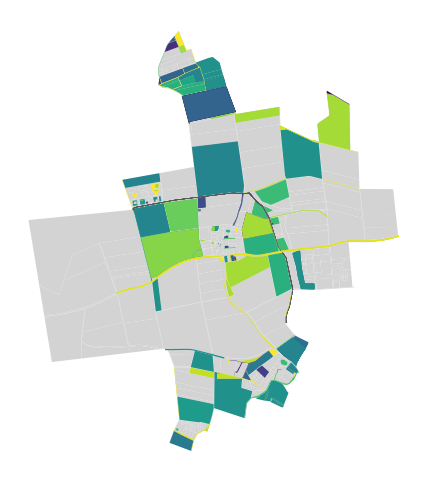

In [201]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_flur_nutz.plot(ax=ax, color='lightgrey')
gdf_flur_nutz[(gdf_flur_nutz["nutzart"]=="Landwirtschaft")&(gdf_flur_nutz["flaeche"]>1000)].plot(column='nutzart', ax=ax, cmap='viridis')
ax.set_axis_off()   

## Neighbour items for "flurstueck" with flstnrzae = 141

### Sedona

In [ ]:
# Select the neighbors of the "flurstueck" with flstnrzae =="141"
result = sedona.sql(f"""
    SELECT f1.gml_id AS flurstueck_id, f2.gml_id AS neighbor_id, f2.flaeche AS neighbor_flaeche
    FROM (
        SELECT gml_id
        FROM flurstueck
        WHERE flstnrzae =="141"
    ) f1
    JOIN flurstueck f2
    ON ST_Touches(f2.geometry, f1.geometry) AND f2.gml_id <> f1.gml_id
""")

### GeoPandas 

In [ ]:
gdf_touches = gpd.sjoin(gdf_flurstueck[gdf_flurstueck["flstnrzae"]=="141"], gdf_flurstueck, how="right", op="touches")

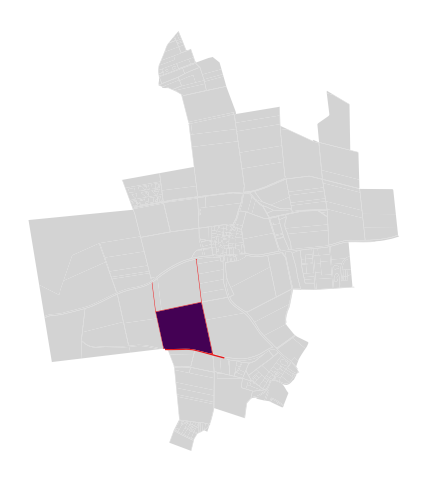

In [226]:
flstnrzae=141
fig, ax = plt.subplots(figsize=(12, 6))                 # map size
gdf_flurstueck.plot(ax=ax, color='lightgrey')                     # underying map
gdf_flurstueck[(gdf_flurstueck["flstnrzae"]=="141")].plot(column='flaeche', ax=ax, cmap='viridis')   # map plotted over the underying map # some values are missing
gdf_touches.plot(column='flaeche_left', ax=ax, cmap='Set1')   # map plotted over the underying map # some values are missing
ax.set_axis_off()

### Visualisation Using Folium API for Leaflet 

In [197]:
import folium
# plot base map
m = folium.Map(location=[49.599810562373584, 9.917171680546457], # center of the folium map
               tiles='cartodbpositron', # type of map
               zoom_start=13) # initial zoom

def style_1(x):
    return {"color":"grey", "weight":0.3}
def style_2(x):
    return {"color":"black", "weight":0.3}
def style_3(x):
    return {"color":"blue", "weight":0.3}


folium.GeoJson(
    gdf_flurstueck,
    style_function=style_3,
    popup=folium.GeoJsonPopup(gdf_flurstueck.drop(columns=["geometry","flstnrnen"]).columns.tolist()),
).add_to(m)


folium.GeoJson(
    gdf_flur_nutz,
    style_function=style_3,
    popup=folium.GeoJsonPopup(gdf_flur_nutz.drop(columns=["geometry","flstnrnen"]).columns.tolist()),
).add_to(m)


folium.GeoJson(
    gdf_gebaeudebauwerk,
    style_function=style_2,
    popup=folium.GeoJsonPopup(gdf_gebaeudebauwerk.drop(columns=["geometry"]).columns.tolist()),
).add_to(m)

gdf_katasterbezirk = gpd.read_file('testdaten_alkis_shape_25832/ALKIS-Vereinfacht/KatasterBezirk.shp')
gdf_verwaltungseinheit = gpd.read_file('testdaten_alkis_shape_25832/ALKIS-Vereinfacht/VerwaltungsEinheit.shp')

m

In [203]:
m.save("flurstuecke.html")

### Apply of a Quadtree on Flurstuecke

In [ ]:
from sedona.core.SpatialRDD import SpatialRDD

# Create a SpatialRDD from the Sedona DataFrame
sdf = sdf_flurstueck  
srdd = SpatialRDD(sdf)

# Apply a Quad-Tree spatial partitioning
srdd.rawSpatialRDD().partitionBy(org.apache.sedona.core.enums.GridType.QUADTREE)